# Análisis y procesamiento de señales - Trabajo semanal Nº 7
# Aramayo Yohana Valentina #


En esta tarea semanal vamos a explorar el filtrado de una señal de electrocardiograma (ECG) mediante distintos métodos, en particular utilizando filtros digitales, tanto FIR como IIR.

Los filtros FIR (de respuesta al impulso finita) se caracterizan por ser siempre estables, lo que significa que su respuesta siempre converge y no presenta oscilaciones indefinidas. Una de sus ventajas es la posibilidad de tener fase lineal, lo cual evita la distorsión temporal de la señal, algo especialmente útil en el procesamiento de señales biomédicas como el ECG. Sin embargo, una limitación importante de los filtros FIR es su alto costo computacional, ya que para cumplir con determinadas especificaciones de diseño (por ejemplo, una banda de transición angosta), requieren un orden elevado.

Por otro lado, los filtros IIR (de respuesta al impulso infinita) pueden lograr especificaciones similares con un orden mucho menor, lo que los hace más eficientes desde el punto de vista computacional. No obstante, presentan desventajas como la distorsión de fase, lo que puede alterar la morfología de la señal. Este efecto se observa, por ejemplo, cuando se aplica un filtrado causal con la función filtfilt. Para mitigar esta distorsión, se suele utilizar filtrado bidireccional, el cual aplica el filtro hacia adelante y hacia atrás en el tiempo. Este método anula la distorsión de fase, pero puede provocar la pérdida de información al comienzo y al final de la señal, especialmente si los bordes no están bien tratados.

En el caso del ECG las frecuencias de interés son relativamente bajas frecuencias aproximadamente hasta los 30/35 Hz.
Al medir la señal eléctrica del corazón de una persona incorporamos ruido de altas y bajas frecuencias que introducen energía en esas frecuencias e impiden una correcta visualización de la información relevante. Es por ello necesaria la implementación de filtros.
Lo lo que requerimos es:
- Filtro Pasa altos: Para filtrar todas las señales de bajas frecuencias que introducen una gran cantidad de energía. Estas se deben a la propia  respiración del paciente, el movimiento de electrodos o el desplazamiento de la línea de base.
- Filtro Pasa bajos: Es requerido para filtrar las altas frecuencias como las debidas al movimiento muscular o de la red eléctrica
- Filtrar señal de la red: En nuestro caso, la plantilla del filtro pasa bajos ya permite eliminar la interferencia de la red eléctrica, ya que la frecuencia de corte se encuentra por debajo de los 50 Hz. Esta frecuencia corresponde a la señal de la red eléctrica en muchos países, y su presencia en el ECG se debe a los dispositivos conectados a dicha red. Además, los armónicos de esta señal también pueden introducir ruido en la señal. Sin embargo, como están por fuera de la banda de paso y dentro de la banda de atenuación del filtro, también son eliminados eficazmente.

Como vemos, vamos a requerir que nuestra señal sea filtrada de frecuencias bajas y altas. En definitiva tenemos que diseñar la plantilla de un filtro pasa banda. 


Los valores que hay que establecer para armar la plantilla de un filtro son:

Ripple: Es la máxima atenuación aceptada en la banda de paso de nuestro filtro. 

Fstop: La frecuencia donde empieza la banda de stop. Las frecuencias estan atenuadas consideradamente a partir de esta frecuencia y son las frecuencias que queremos filtrar.

Fpass: Determina las frecuencias en la que el filtro es inocuo.

Atenuación: Va a ser la mínima atenuación a la que se va a someter la señal en la banda de stop. 

**Filtro pasa altos**

Fstop= 0,1 Hz

Fpass= 1Hz

Ripple= 1

Atenuación= 40 db 

Estos parámetros fueron definidos así para filtrar todas las frecuencias menores que 0,1 que introducen una gran cantidad de energía en la señal. Luego a partir de 1 Hz pasan todas las frecuencias, las cuales son de nuestro interés pues tienen información vital sobre ECG.

**Filtro pasa bajos** 

Fstop= 50Hz

Fpass= 35Hz

Ripple= 1

Atenuación= 40 db  

En el pasa bajos definimos que la frecuencias a partir de 50 Hz formen parte de la banda de stop, con un gran grado de atenuación. De 35 a 50 Hz tenemos la banda de transición. 
La frecuencia de stop fue definida en 50 Hz para por un lado hacerlo coincidir con la frecuencia de la red pero tranquilamente podría haber sido mayor. De hecho el ancho de banda generalmente suele ser hasta 150 Hz para tener una alta resolución y captar movimientos bruscos y nos perderse los detalles de la señal. Sin embargo, eso es algo más sofisticado. tendríamos que haber hecho pasa altos, notch y pasa bajos. Para los fines de la materia un ancho de banda hasta 35Hz va bien. Además con un ancho de banda hasta 150 habríamos captado también más ruido muscular.


In [51]:
import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla, group_delay
def visualizar_ecg_por_tipo(ecg_original, ecg_filtrados, etiquetas, fs=1000, demora=0,
                            regs_interes=None, titulo='', mostrar=1, axs=None):
    colores_por_filtro = {
        'ventana': 'pink',
        'remez': 'purple',
        'firls': 'seagreen',
        'butter': 'indigo',
        'ellip': 'cyan',
        'chevyshev': 'red'
    }

    if regs_interes is None:
        regs_interes = (
            [4000, 5500],
            [10e3, 11e3],
            np.array([5, 5.2]) * 60 * fs,
            np.array([12, 12.4]) * 60 * fs,
            np.array([15, 15.2]) * 60 * fs,
        )

    if isinstance(demora, int):
        demora = [demora] * len(ecg_filtrados)

    N = len(ecg_original)
    figs = []

    # Si el usuario no pasó ejes (axs), crear uno nuevo por región
    crear_figura = axs is None
    if axs is not None and len(regs_interes) == 1:
        axs = [axs]  # lo volvemos lista para iterar

    for idx, ii in enumerate(regs_interes):
        zoom_region = np.arange(int(max(0, ii[0])), int(min(N, ii[1])), dtype='uint')

        if crear_figura:
            fig, ax = plt.subplots(figsize=(10, 4))
        else:
            ax = axs[idx]
            fig = ax.figure

        ax.plot(zoom_region, ecg_original[zoom_region], label='ECG original', linewidth=1.5, color='gray')

        for i, etiqueta in enumerate(etiquetas):
            
            dr = demora[i] if i < len(demora) else 0
            color = colores_por_filtro.get(etiqueta.lower(), 'black')
            # Protegemos el índice para que no se pase del largo
            shift_indices = zoom_region + dr
            shift_indices = shift_indices[shift_indices < len(ecg_filtrados[i])]
            ax.plot(shift_indices, ecg_filtrados[i][shift_indices], label=etiqueta.capitalize(), color=color, linewidth=1.5)

        ax.set_title(f'{titulo} - Región: {int(ii[0])} a {int(ii[1])}')
        ax.set_ylabel('Amplitud [adim]')
        ax.set_xlabel('Muestras (#)')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()

        figs.append(fig)

    if mostrar == 1 and crear_figura:
        for f in figs:
            plt.show()
    else:
        return figs

# ==============================
# CARGAR ECG
# ==============================

mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
ecg_one_lead=ecg_one_lead/np.std(ecg_one_lead)
N = len(ecg_one_lead)
demora=200
# Frecuencia de muestreo
fs = 1000
nyquist = fs / 2


<div align="center">
    <h2><strong>FILTROS FIR </strong></h2>
</div>

**Construcción del filtro pasa banda mediante convolución de filtros**
Para el método de ventanas, se diseñaron por separado un filtro pasa bajos y un filtro pasa altos, y luego se los convolucionó en el dominio del tiempo. Recordemos, según la transformada de Fourier, que una convolución en el tiempo equivale a una multiplicación en el dominio de la frecuencia. Por lo tanto, al multiplicar las respuestas en frecuencia del pasa bajos y del pasa altos, se obtiene un filtro pasa banda, cuya banda pasante es la intersección de las bandas pasantes de ambos filtros.

Se optó por esta estrategia debido a la antisimetría de la respuesta impulsiva en los filtros pasa banda construidos directamente con ventanas, lo cual complica el diseño directo. En cambio, convolucionando un pasa altos con un pasa bajos, se logra una respuesta que cumple con las condiciones deseadas de fase y forma.

**Diseño con métodos de mínimos cuadrados y Remez**
En cambio, para los métodos de mínimos cuadrados y Remez, se utilizó un diseño directo del filtro pasa banda, con una respuesta simétrica en las bandas de transición. Para lograrlo, se ajustaron los parámetros del filtro pasa bajos para que tuviera la misma banda de transición que el filtro pasa altos, ya que este último resultó ser más exigente en términos de pendiente y atenuación. Este ajuste fue necesario para que el filtro combinado cumpliera adecuadamente con la plantilla especificada.

<div align="center">
    <h2><strong>VENTANAS </strong></h2>
</div>

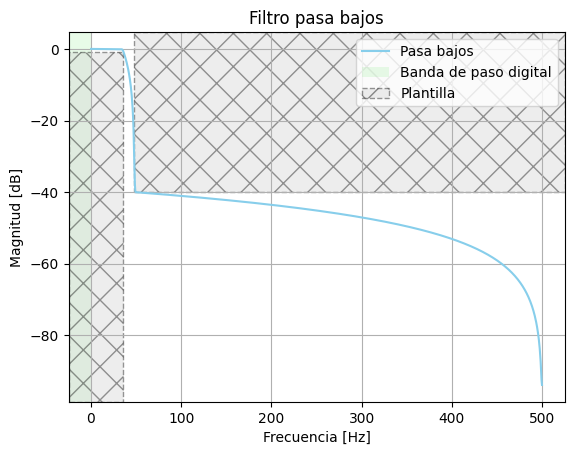

In [52]:
# ==============================
# DISEÑO DEL FILTRO PASA BAJOS
# ==============================
# Tamaño de los filtros
cant_coef_lp = 2001
cant_coef_hp = 5301
filter_type = 'lowpass'
fpass_lp = 35  # Hz
fstop_lp = 48  # Hz con esto llega a atenuar bien a 50 hz
ripple = 0.1   # dB
attenuation = 40  # dB

frecs_lp = [0.0, fpass_lp, fstop_lp, nyquist]
gains_db_lp = [0, -ripple, -attenuation, -100]
gains_lp = 10**(np.array(gains_db_lp)/20)

num_lp = sig.firwin2(cant_coef_lp, frecs_lp, gains_lp, window=('kaiser', 14), fs=fs)

# Visualización del pasa bajos
w_rad = 2 * np.pi * np.linspace(0.1, nyquist, 1000) / fs
w, hh_lp = sig.freqz(num_lp, worN=w_rad)

plt.figure(1)
plt.plot(w / np.pi * fs / 2, 20 * np.log10(np.abs(hh_lp) + 1e-15), label='Pasa bajos', color='skyblue')
plot_plantilla(filter_type='lowpass', fpass=fpass_lp, ripple=1, fstop=fstop_lp, attenuation=attenuation)
plt.title('Filtro pasa bajos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

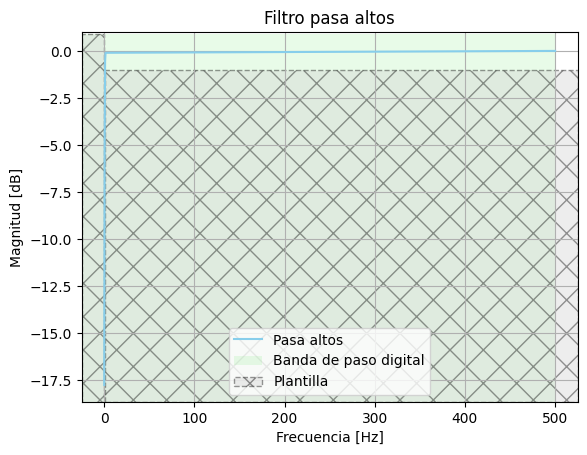

In [53]:
# ==============================
# DISEÑO DEL FILTRO PASA ALTOS
# ==============================

filter_type = 'highpass'
fstop_hp = 0.1  # Hz
fpass_hp = 1.0  # Hz

frecs_hp = [0.0, fstop_hp, fpass_hp, nyquist]
gains_db_hp = [-np.inf, -attenuation, -ripple, 0]
gains_hp = 10**(np.array(gains_db_hp)/20)

num_hp = sig.firwin2(cant_coef_hp, frecs_hp, gains_hp, window=('kaiser', 14), fs=fs)

# Visualización del pasa altos
w, hh_hp = sig.freqz(num_hp, worN=w_rad)

plt.figure(2)
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(np.abs(hh_hp) + 1e-15), label='Pasa altos', color='skyblue')
plot_plantilla(filter_type='highpass', fpass=fpass_hp, ripple=1, fstop=fstop_hp, attenuation=attenuation, fs=fs)
plt.title('Filtro pasa altos')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()


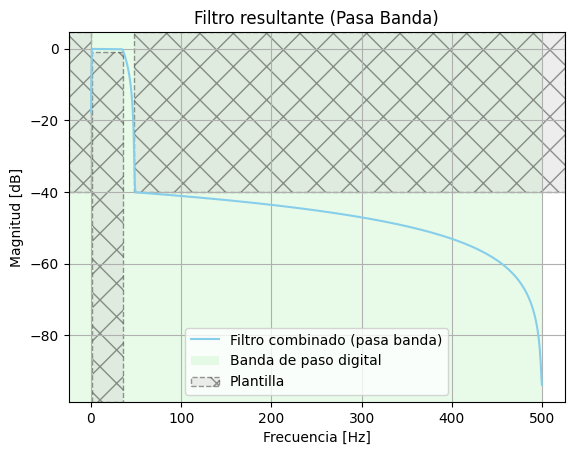

In [54]:
# ==============================
# CONVOLUCIÓN: FILTRO PASA BANDA
# ==============================

num_total = np.convolve(num_lp, num_hp)
w, h_total = sig.freqz(num_total, worN=w_rad)

plt.figure(3)
plt.plot(w * fs / (2 * np.pi), 20 * np.log10(np.abs(h_total) + 1e-15), label='Filtro combinado (pasa banda)', color='skyblue')
plot_plantilla(filter_type='bandpass', fpass=(fpass_hp, fpass_lp), ripple=1, fstop=(fstop_hp, fstop_lp), attenuation=attenuation, fs=fs)
plt.title('Filtro resultante (Pasa Banda)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

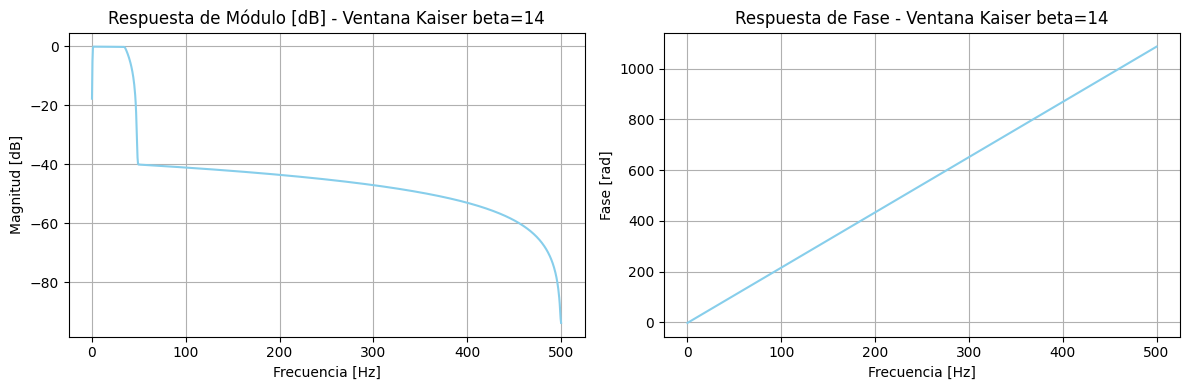

In [55]:
# Calcular módulo y fase
moduloH = np.abs(h_total)
moduloH_db = 20 * np.log10(moduloH)  # Conversión a decibeles
faseH = np.unwrap(np.angle(h_total))

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Módulo en dB
axs[0].plot(w / np.pi * fs / 2, moduloH_db, color='skyblue')
axs[0].set_title('Respuesta de Módulo [dB] - Ventana Kaiser beta=14')
axs[0].set_xlabel('Frecuencia [Hz]')
axs[0].set_ylabel('Magnitud [dB]')
axs[0].grid(True)

# Fase
axs[1].plot(w / np.pi * fs / 2, faseH, color='skyblue')
axs[1].set_title('Respuesta de Fase - Ventana Kaiser beta=14')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set_ylabel('Fase [rad]')
axs[1].grid(True)

plt.tight_layout()
plt.show()


Agregar respuesta de fase y modulo de pasabanda 

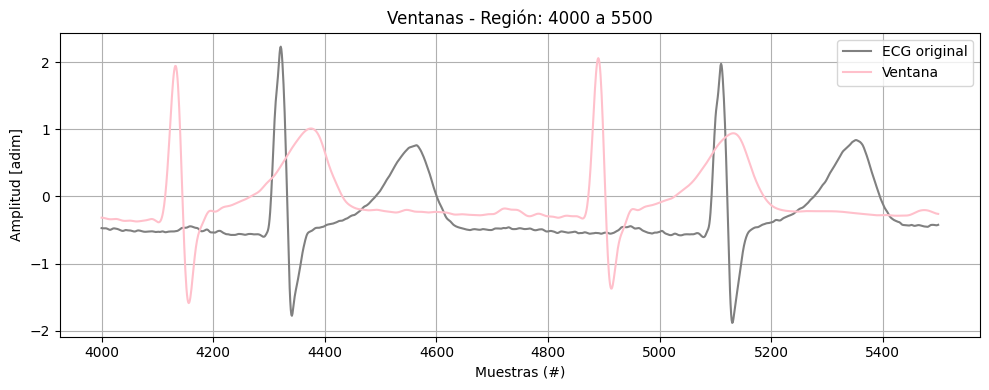

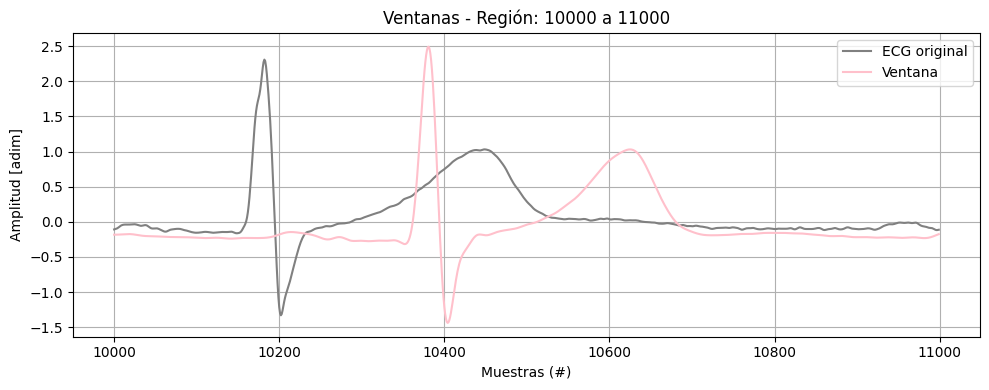

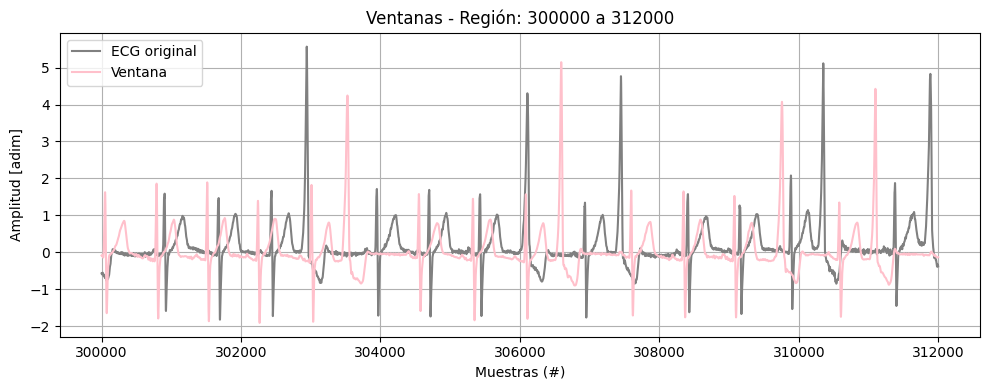

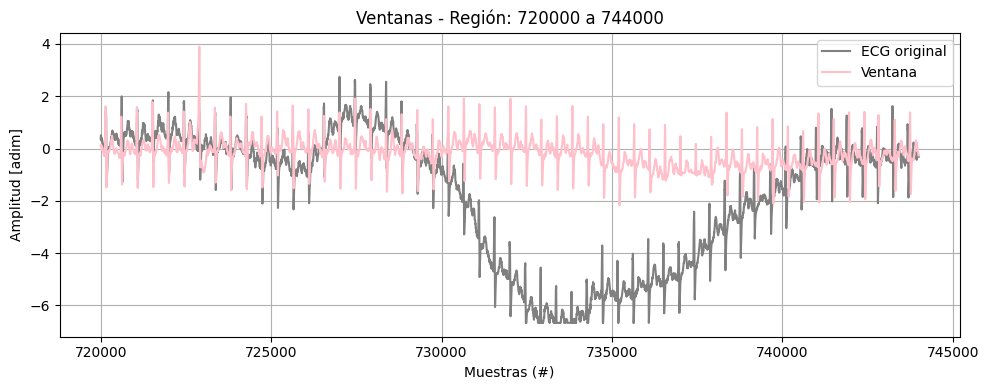

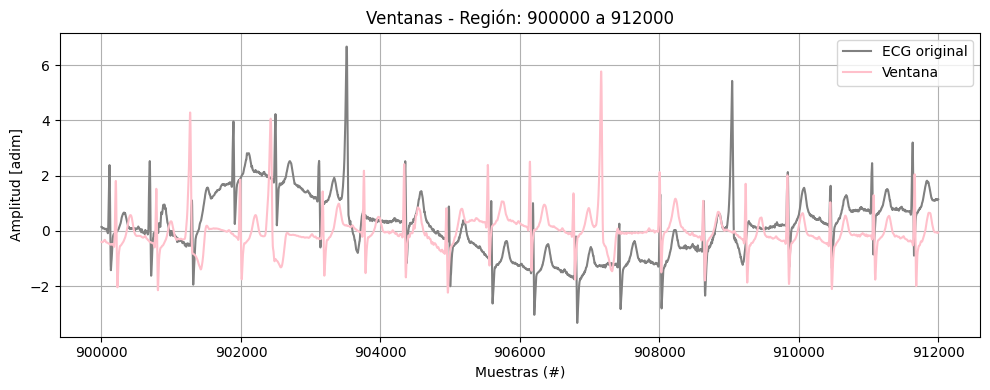

In [56]:
# ==============================
# FILTRADO CON VENTANA
# ==============================

ecg_filtrado_window = sig.lfilter(num_total, 1, ecg_one_lead) #1 porque es un filt
# plt.plot(ecg_filtrado)
# plt.plot(ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_window],
    etiquetas=['ventana'],
    demora=[0],
    titulo='Ventanas'
)


<div align="center">
    <h2><strong>CUADRADOS MÍNIMOS </strong></h2>
</div>

In [57]:
# %%
# cargo valores para cuadrados minimos y remez
# frecuencia de muestreo normalizada
fs = 1000
nyquist=fs/2
# tamaño de la respuesta al impulso
cant_coef = 1501 #explicar pq van coeficientes impares
filter_type = 'bandpass'

fpass = np.array([1., 35.])   
fstop = np.array([.1, 50.])  
ripple = 0.5 # dB
attenuation = 40 # dB

# construyo la plantilla de requerimientos
f = np.array([0, fstop[0], fpass[0], fpass[1], fpass[1]+1, nyquist]) # fpass[1]+1
hh = np.array([0, 0, 1, 1, 0, 0])

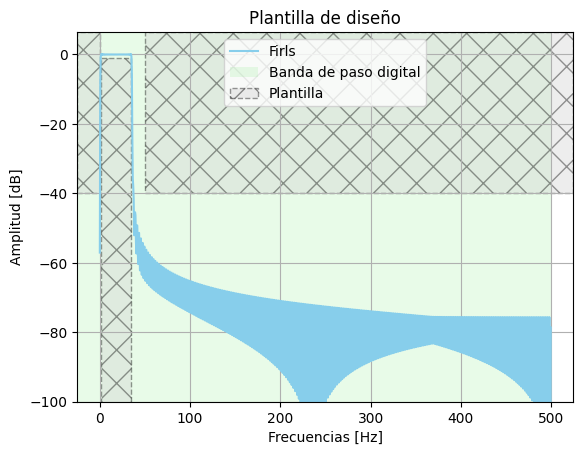

In [58]:
# %%
   # CUADRADOS MÍNIMOS
# Diseño del filtro
Filtro_cuadrado= sig.firls(numtaps = 1501, bands = f, desired = hh, fs = 1000)
# Es necesario tener orden impar!! Estudiar esto de los filtros fir
npoints=1000
# hh = sig.firls(numtaps = 1501, bands = f, desired = hh, fs = 1000)
w, hh_firls = sig.freqz(Filtro_cuadrado, worN=npoints) # <interpoló> los puntos obtenidos

plt.figure()
plt.plot(w/np.pi * fs / 2, 20*np.log10(np.abs(hh_firls )+1e-15), label='Firls', color='skyblue')

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencias [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plot_plantilla(filter_type='bandpass', fpass=(fpass[0], fpass[1]), ripple=1, fstop=(fstop[0], fstop[1]), attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

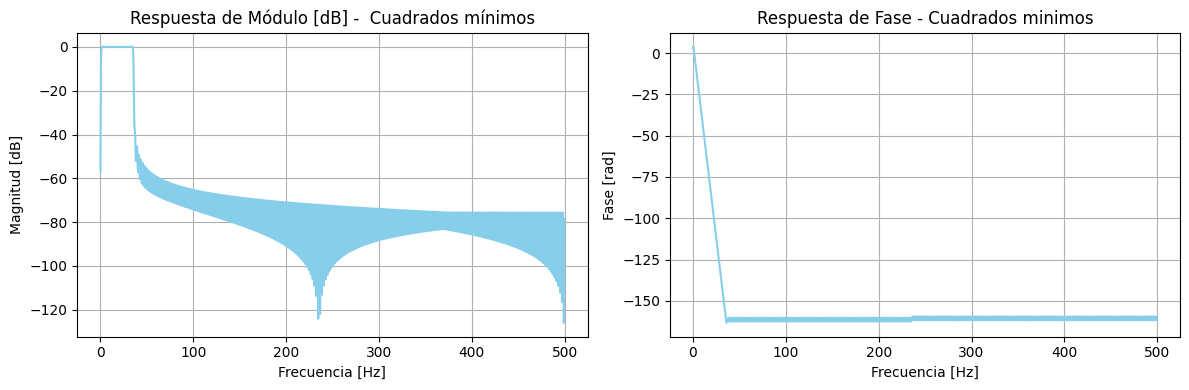

In [59]:
# Calcular módulo y fase
moduloH = np.abs(hh_firls)
moduloH_db = 20 * np.log10(moduloH)  # Conversión a decibeles
faseH = np.unwrap(np.angle(hh_firls))

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Módulo en dB
axs[0].plot(w / np.pi * fs / 2, moduloH_db, color='skyblue')
axs[0].set_title('Respuesta de Módulo [dB] -  Cuadrados mínimos')
axs[0].set_xlabel('Frecuencia [Hz]')
axs[0].set_ylabel('Magnitud [dB]')
axs[0].grid(True)

# Fase
axs[1].plot(w / np.pi * fs / 2, faseH, color='skyblue')
axs[1].set_title('Respuesta de Fase - Cuadrados minimos')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set_ylabel('Fase [rad]')
axs[1].grid(True)

plt.tight_layout()
plt.show()


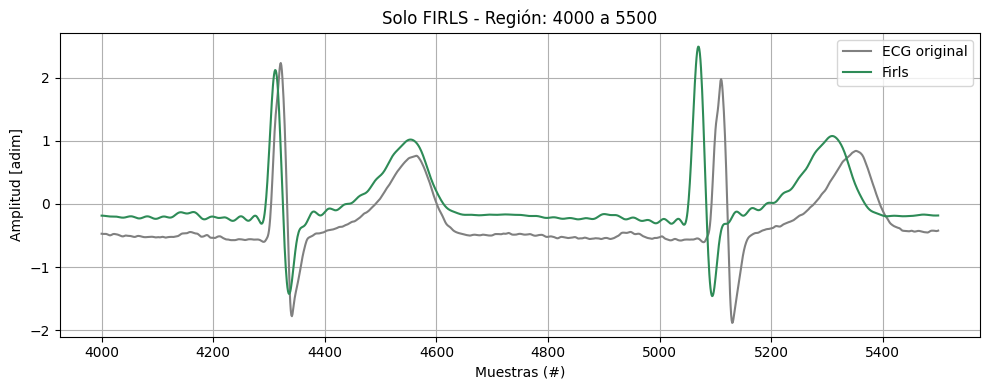

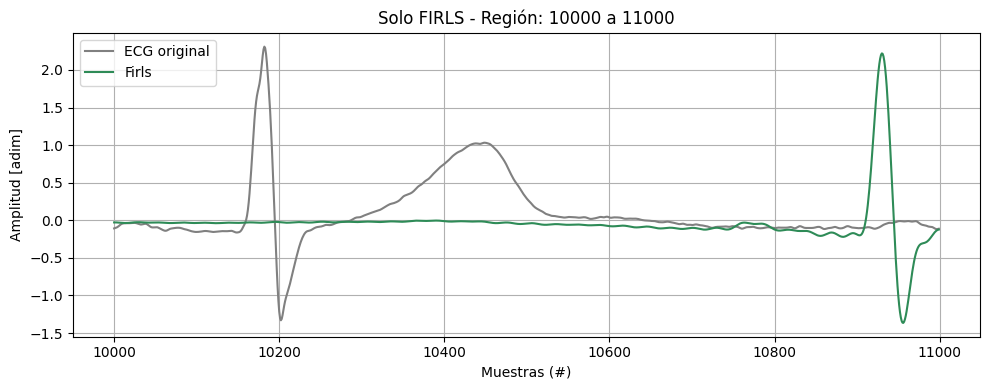

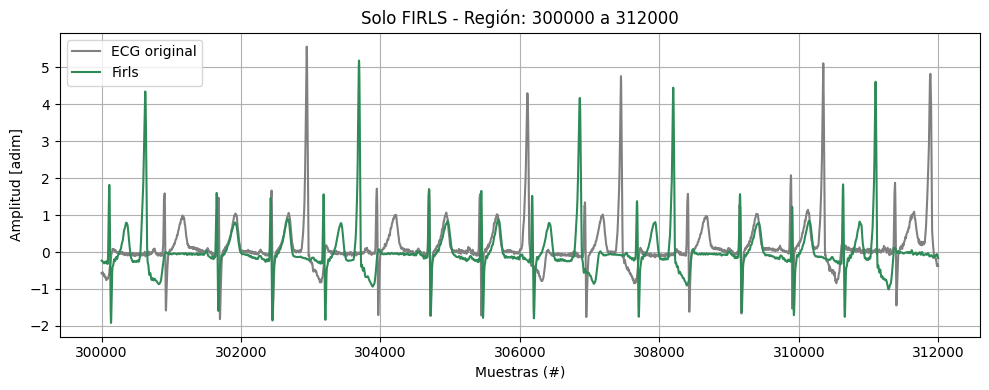

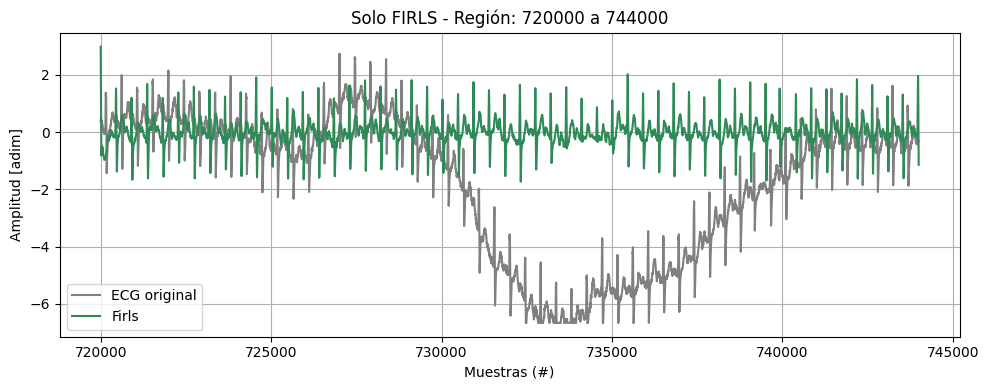

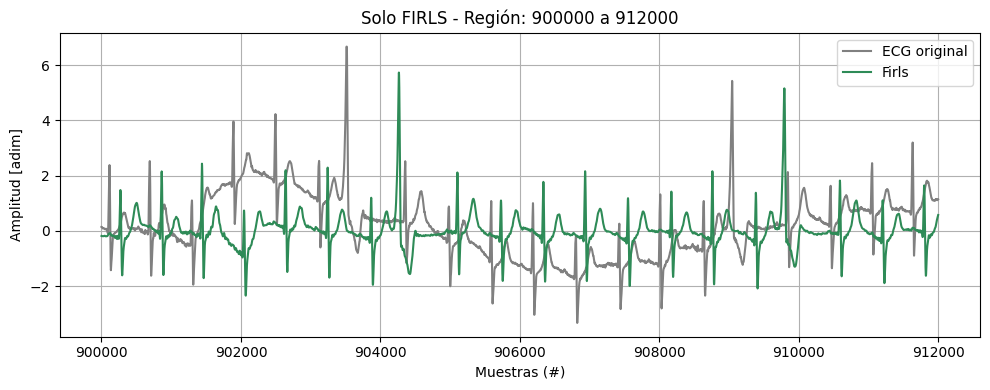

In [60]:
#VER GRAFICOS
ecg_filtrado_cuadrado = sig.lfilter(Filtro_cuadrado, 1, ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_cuadrado],
    etiquetas=['firls'],
    demora=[0],
    titulo='Solo FIRLS'
)


<div align="center">
    <h2><strong>PARKS MC CLELLAN REMEZ </strong></h2>
</div>

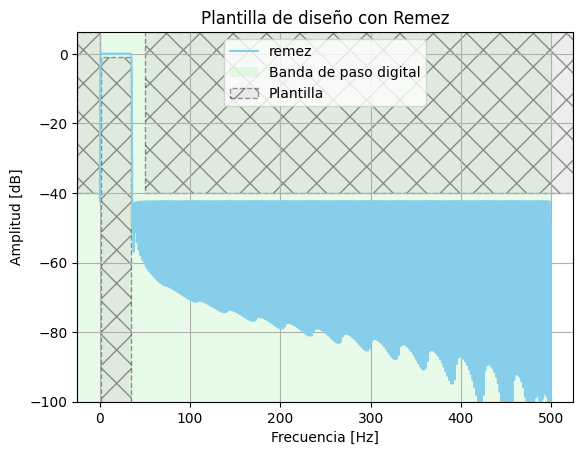

In [61]:
# %%
# PM - REMEZ
# # Diseño del filtro
Filtro_remez = sig.remez(numtaps = 2501, bands = f, desired=hh[::2], fs = 1000)
w, hh_remez = sig.freqz(Filtro_remez, worN=npoints)
plt.figure()
plt.plot(w / np.pi * fs / 2, 20 * np.log10(np.abs(hh_remez) + 1e-15), label='remez', color= 'skyblue')
plt.title('Plantilla de diseño con Remez')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')
plot_plantilla(filter_type='bandpass', fpass=(fpass[0], fpass[1]), ripple=1, fstop=(fstop[0], fstop[1]), attenuation=attenuation, fs=fs)
plt.legend()
plt.show()

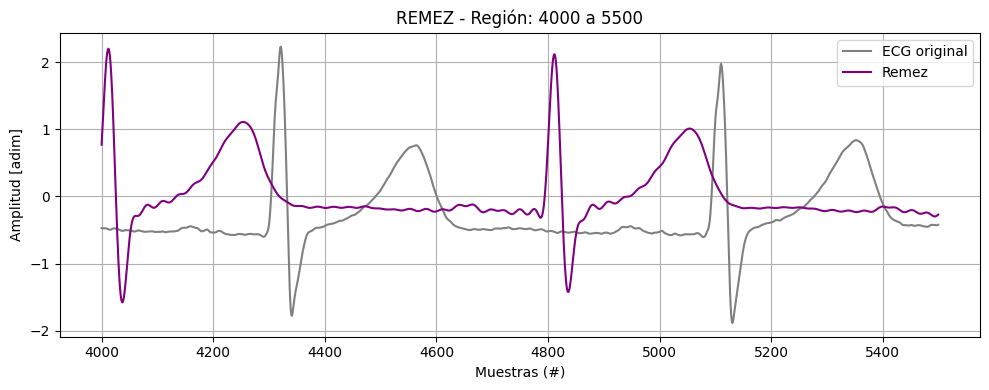

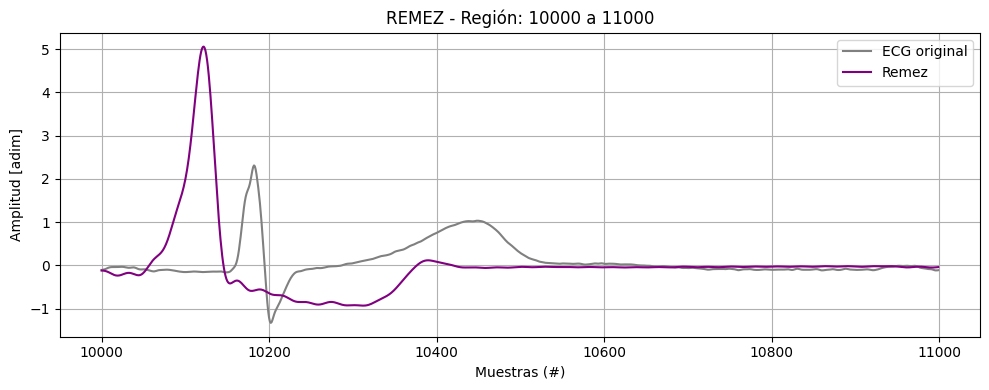

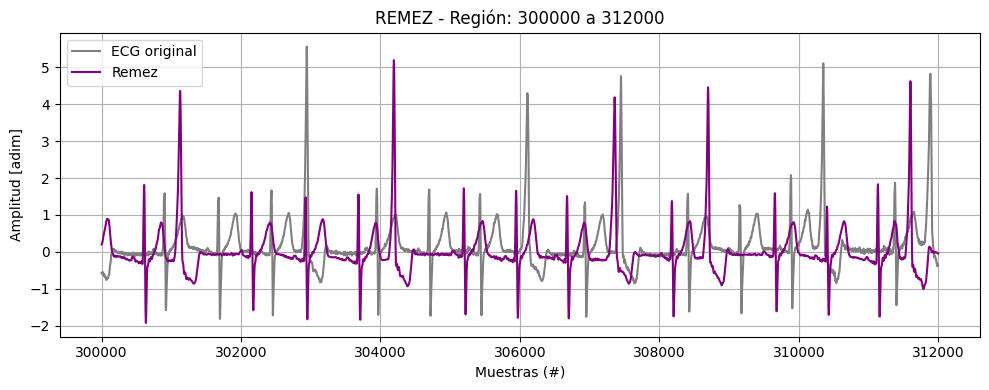

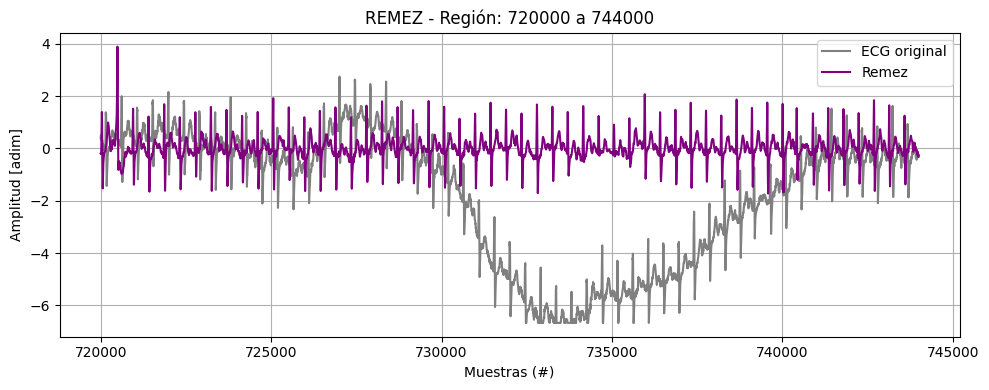

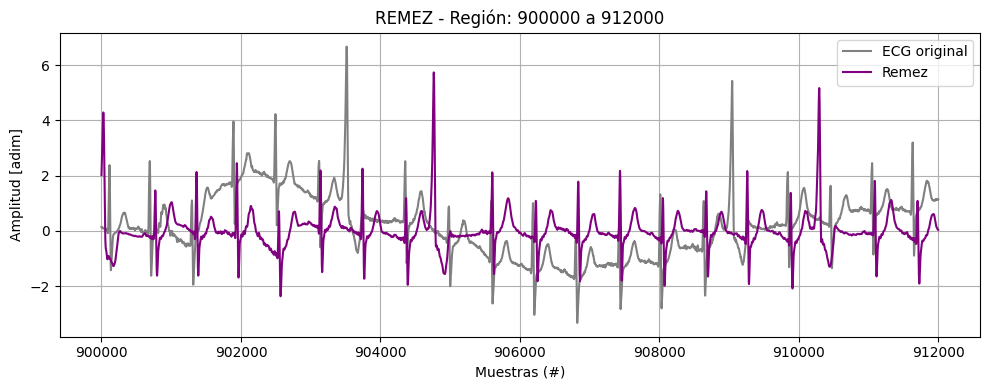

In [62]:
#VER GRAFICOS
ecg_filtrado_remez = sig.lfilter(Filtro_remez, 1, ecg_one_lead)
visualizar_ecg_por_tipo(
    ecg_original=ecg_one_lead,
    ecg_filtrados=[ecg_filtrado_remez],
    etiquetas=['remez'],
    demora=[0],
    titulo='REMEZ'
)

Al comparar estos tres enfoques, se observa que el método de ventanas es el que presenta peor desempeño en la atenuación de altas frecuencias (es decir, en la banda de detención). Esto podría deberse a que la atenuación en la banda de transición no es constante, sino que sigue una curva determinada por la forma de la ventana utilizada.

En este caso, se utilizó una ventana de Kaiser, aunque una ventana de Hamming también habría sido adecuada, ya que tiene una transición más suave y controlada. La Kaiser, al intentar cumplir con una transición abrupta, genera un recorte más "recto", pero a veces eso puede invadir parcialmente la banda de detención (stopband), comprometiendo el cumplimiento de la plantilla.

Para corregir este problema, fue necesario ajustar la atenuación: en el diseño del filtro pasa bajos, se modificó la plantilla para exigir que a los 48 Hz la atenuación ya alcance 40 dB, de modo que se respete el requerimiento. Una modificación similar se aplicó al filtro pasa altos, donde se ajustó el ripple en la banda de paso, ubicándolo en 0,1 Hz para asegurar que el filtro cumpla con la especificación deseada también en bajas frecuencias.

**Fase lineal y retardo constante en filtros FIR**
Como se mencionó anteriormente, una de las ventajas de los filtros FIR es la posibilidad de diseñarlos con fase lineal. Esto implica que el retardo de grupo es constante en todas las frecuencias, lo que significa que todas las componentes de la señal se retrasan por igual. Matemáticamente, esto se debe a que el retardo es la derivada de la fase respecto a la frecuencia; por lo tanto, una fase lineal da lugar a un retardo constante.

En el caso del filtrado del ECG, esta propiedad se traduce en un desplazamiento temporal uniforme de toda la señal. Esta demora es fácilmente corregible: observando los gráficos, se puede calcular la cantidad de muestras de retardo introducido por el filtro (por ejemplo, la mitad del orden del filtro si es simétrico), y luego alinear la señal filtrada desplazándola hacia la izquierda.

Una vez corregido el retardo, la señal filtrada se encuentra en fase con la señal original, es decir, no hay distorsión temporal entre los componentes. Esto es especialmente importante en aplicaciones como el ECG, donde la morfología de las ondas (P, QRS, T) debe mantenerse intacta para un análisis clínico correcto.


<div align="center">
    <h2><strong>FILTROS IIR</strong></h2>
</div>
Para los IIR se utilizó las metodologías de Máxima planicidad, Chebyshev y Cauer también conocido como Ellip. 
Para cada uno de estos filtros se graficó tanto la respuesta de fase como la de módulo.
<div align="center">
    <h2><strong>BUTTER </strong></h2>
</div>

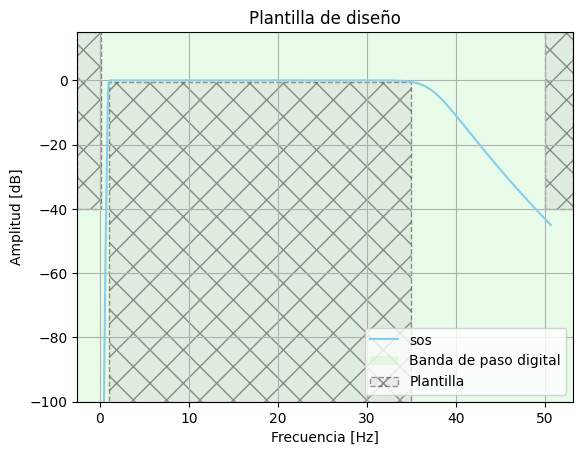

In [63]:
aprox_name = 'butter'
aprox_name2 = 'cheby1'
# aprox_name = 'cheby2'
aprox_name3 = 'ellip'

fs= 1000 #Hz
nyquist=fs/2
fpass = np.array([1.0, 35.0])
ripple = 0.5 # dB
fstop = np.array([.1, 50.])
atenuacion = 40 # dB

sos=sig.iirdesign(fpass,fstop, ripple, atenuacion, ftype=aprox_name, output='sos', fs=fs)
sos2=sig.iirdesign(fpass,fstop, ripple, atenuacion, ftype=aprox_name2, output='sos', fs=fs)
sos3=sig.iirdesign(fpass,fstop, ripple, atenuacion, ftype=aprox_name3, output='sos', fs=fs)
npoints = 1000 
w_rad= np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250)) 
w_rad= np.append(w_rad, np.linspace(40, nyquist, 500, endpoint=True))/ (nyquist* np.pi)
# esto mejoro la resolucion en la subir de 0 a 2 
w, hh = sig.sosfreqz(sos, worN=w_rad)  
w2, hh2 = sig.sosfreqz(sos2, worN=w_rad)  
w3, hh3 = sig.sosfreqz(sos3, worN=w_rad)  
plt.plot(w/np.pi*fs/2, 20*np.log10(np.abs(hh)+1e-15), label='sos', color='skyblue')  
#1e-15 para no tener problemas de cero
# w/np.pi*fs/2 de cero a nyquist
plt.title('Plantilla de diseño')  
plt.xlabel('Frecuencia [Hz]')  
plt.ylabel('Amplitud [dB]')  
plt.grid(which='both', axis='both')  
ax = plt.gca()  
# ax.set_xlim([0, 1])  
# ax.set_ylim([-60, 10])  
plot_plantilla(filter_type = 'bandpass', fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs=fs)  
plt.legend()  
plt.show()  
ecg_filtrado_butter = sig.sosfilt(sos, ecg_one_lead)       # Filtro causal
ecg_filtrado_butter_ff = sig.sosfiltfilt(sos, ecg_one_lead)  # Filtro no causal
ecg_filtrado_chevy = sig.sosfilt(sos2, ecg_one_lead)
ecg_filtrado_chevy_ff = sig.sosfiltfilt(sos2, ecg_one_lead)
ecg_filtrado_ellip = sig.sosfilt(sos3, ecg_one_lead)
ecg_filtrado_ellip_ff = sig.sosfiltfilt(sos3, ecg_one_lead)

<div align="center">
    <h2><strong>BUTTERWORTH </strong></h2>
</div>

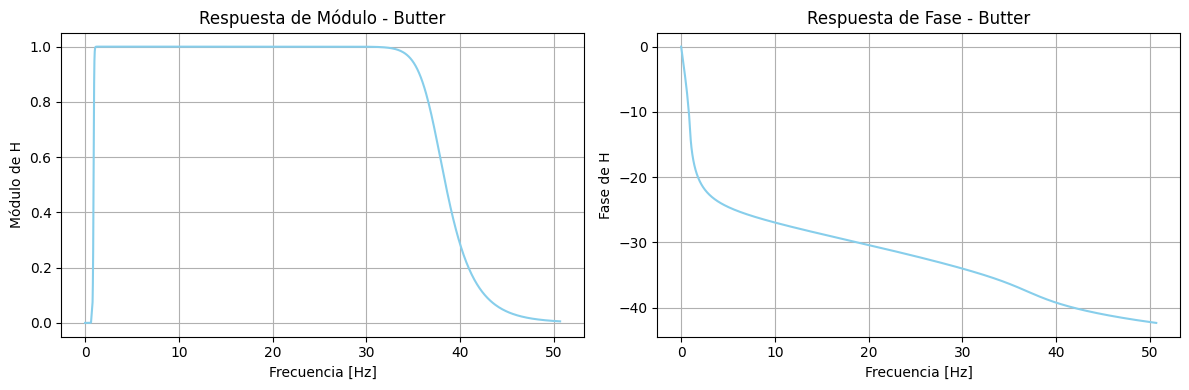

In [64]:
# Calcular módulo y fase
moduloH = np.abs(hh)
faseH = np.unwrap(np.angle(hh))

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Módulo
axs[0].plot(w/np.pi*fs/2, moduloH, color='skyblue')
axs[0].set_title('Respuesta de Módulo - Butter')
axs[0].set_xlabel('Frecuencia [Hz]')
axs[0].set_ylabel('Módulo de H')
axs[0].grid(True)

# Fase
axs[1].plot(w/np.pi*fs/2, faseH, color='skyblue')
axs[1].set_title('Respuesta de Fase - Butter')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set_ylabel('Fase de H')
axs[1].grid(True)

plt.tight_layout()
plt.show()


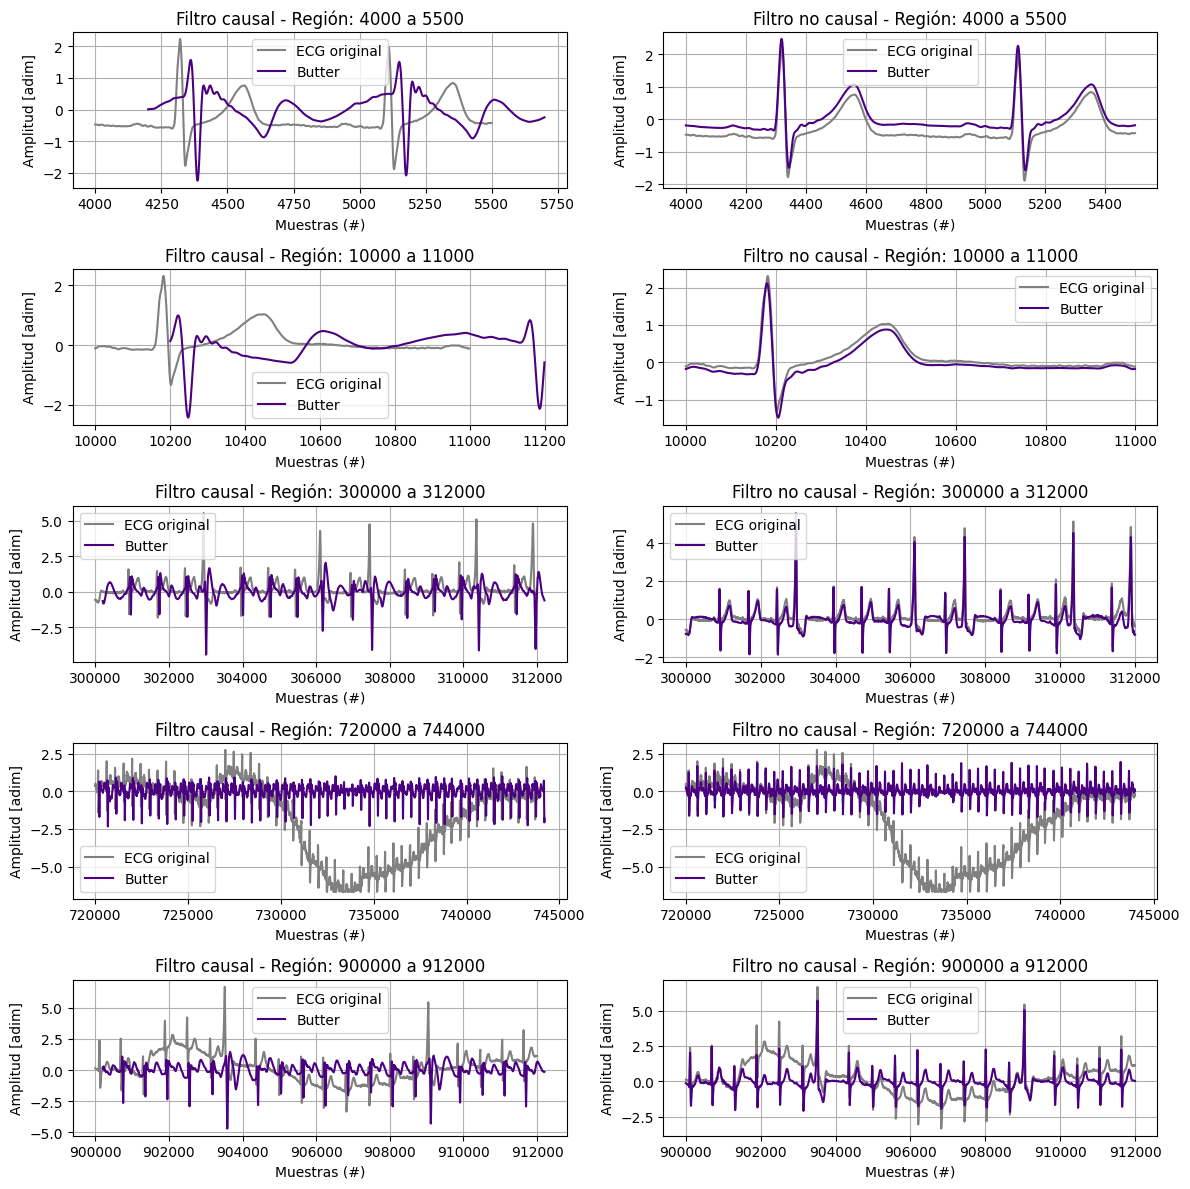

In [65]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))  # 5 regiones, 2 métodos
regs_interes = (
    [4000, 5500],
    [10000, 11000],
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

# Filtro causal en la columna 0
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_butter], ['butter'],
                        demora=[demora], titulo='Filtro causal',
                        mostrar=0, axs=axs[:, 0], regs_interes=regs_interes)

# Filtro no causal en la columna 1
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_butter_ff], ['butter'],
                        demora=[0], titulo='Filtro no causal',
                        mostrar=0, axs=axs[:, 1], regs_interes=regs_interes)

plt.tight_layout()
plt.show()


<div align="center">
    <h2><strong>CHEBYSHEV </strong></h2>
</div>

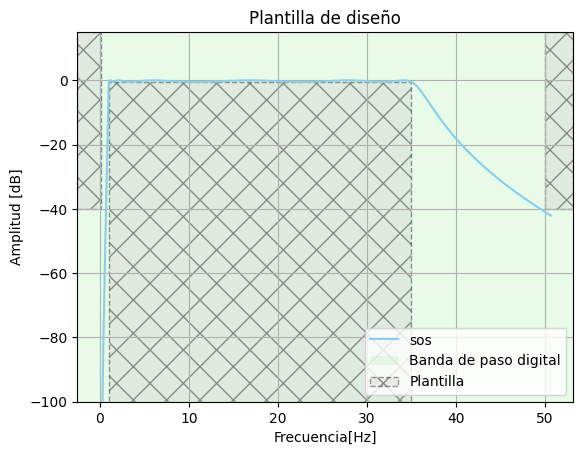

In [66]:
plt.plot(w2/np.pi*fs/2, 20*np.log10(np.abs(hh2)+1e-15), label='sos', color='skyblue')  
#1e-15 para no tener problemas de cero
# w/np.pi*fs/2 de cero a nyquist
plt.title('Plantilla de diseño')  
plt.xlabel('Frecuencia[Hz]')  
plt.ylabel('Amplitud [dB]')  
plt.grid(which='both', axis='both')  
ax = plt.gca()  
# ax.set_xlim([0, 1])  
# ax.set_ylim([-60, 10])  
plot_plantilla(filter_type = 'bandpass', fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs=fs)  
plt.legend()  
plt.show() 

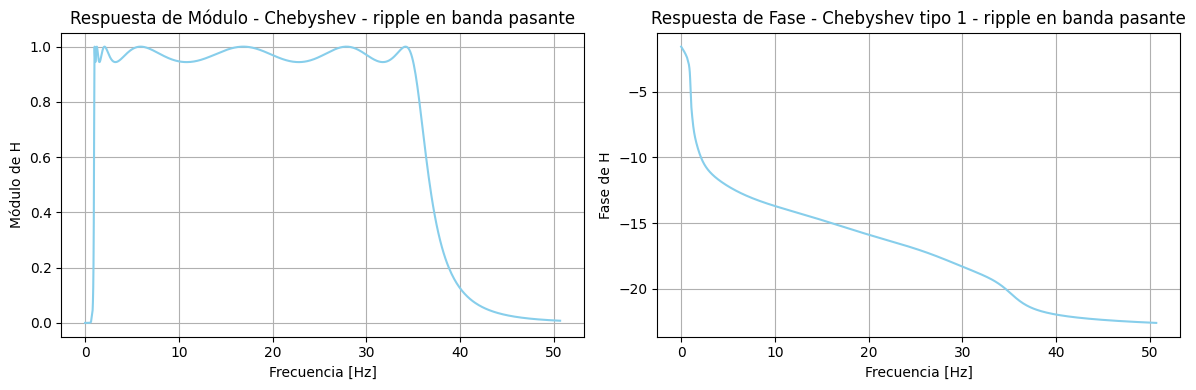

In [67]:
# Calcular módulo y fase
moduloH2 = np.abs(hh2)
faseH2 = np.unwrap(np.angle(hh2))

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Módulo
axs[0].plot(w2/np.pi*fs/2, moduloH2, color='skyblue')
axs[0].set_title('Respuesta de Módulo - Chebyshev - ripple en banda pasante')
axs[0].set_xlabel('Frecuencia [Hz]')
axs[0].set_ylabel('Módulo de H')
axs[0].grid(True)

# Fase
axs[1].plot(w2/np.pi*fs/2, faseH2, color='skyblue')
axs[1].set_title('Respuesta de Fase - Chebyshev tipo 1 - ripple en banda pasante')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set_ylabel('Fase de H')
axs[1].grid(True)

plt.tight_layout()
plt.show()

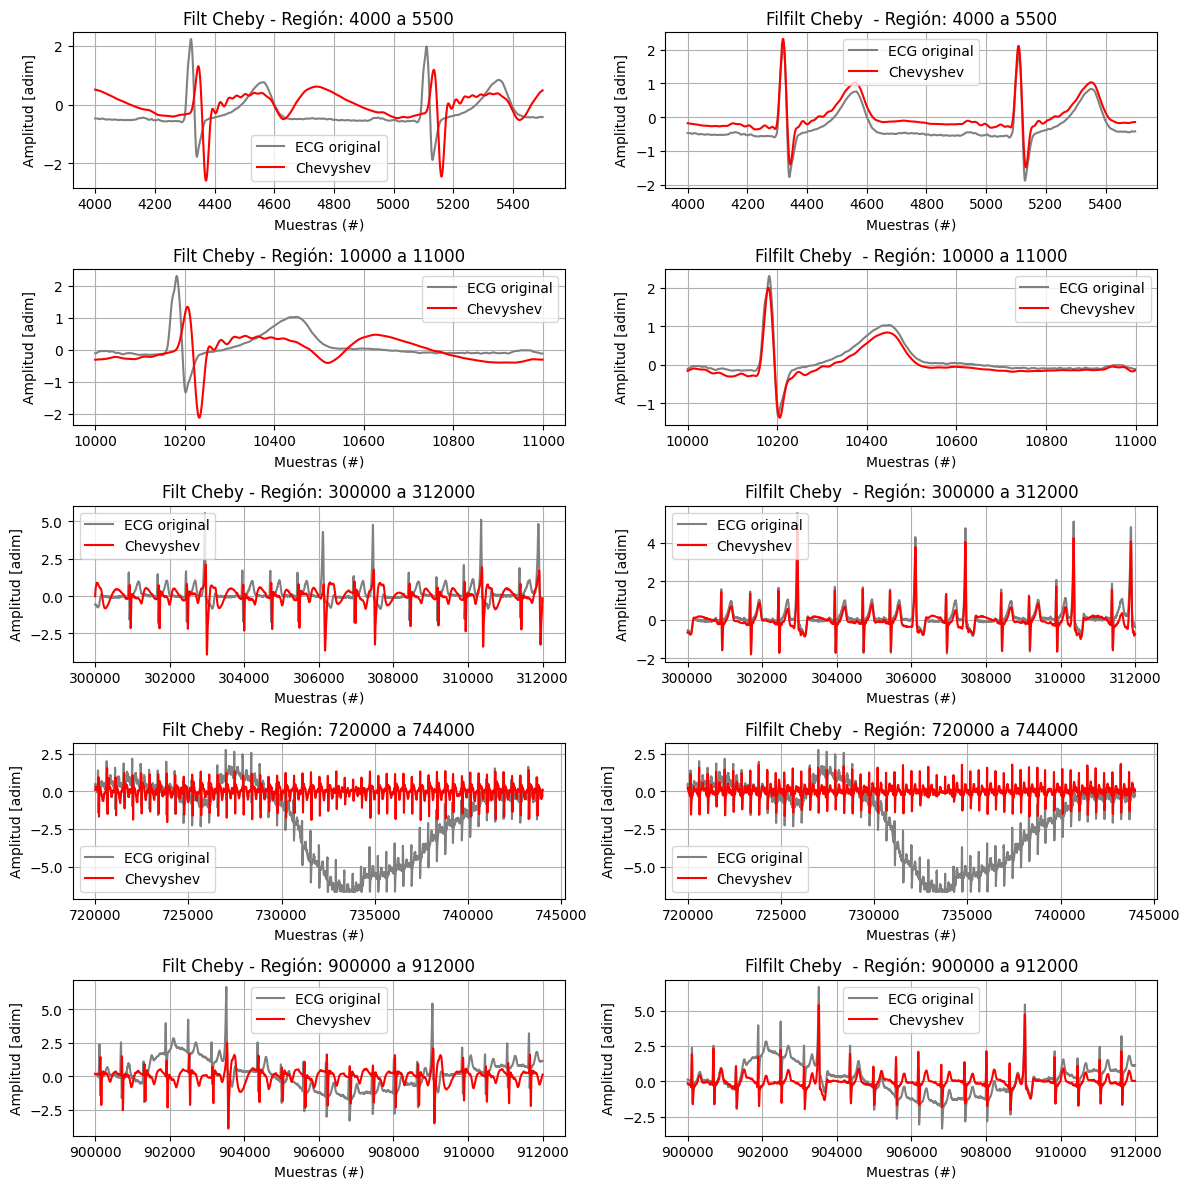

In [68]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))  # 5 regiones, 2 métodos
regs_interes = (
    [4000, 5500],
    [10000, 11000],
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

# Filtro causal en la columna 0
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_chevy], ['chevyshev'],
                        demora=[0], titulo='Filt Cheby',
                        mostrar=0, axs=axs[:, 0], regs_interes=regs_interes)

# Filtro no causal en la columna 1
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_chevy_ff], ['chevyshev'],
                        demora=[0], titulo='Filfilt Cheby ',
                        mostrar=0, axs=axs[:, 1], regs_interes=regs_interes)

plt.tight_layout()
plt.show()

<div align="center">
    <h2><strong>CAUER - ELLIP </strong></h2>
</div>

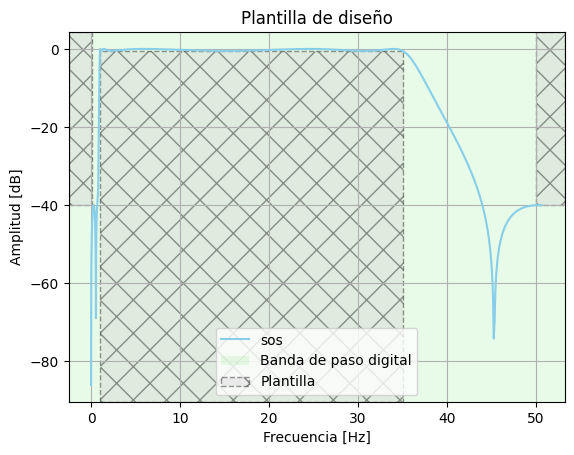

In [69]:
plt.plot(w3/np.pi*fs/2, 20*np.log10(np.abs(hh3)+1e-15), label='sos', color='skyblue')  
#1e-15 para no tener problemas de cero
# w/np.pi*fs/2 de cero a nyquist
plt.title('Plantilla de diseño')  
plt.xlabel('Frecuencia [Hz]')  
plt.ylabel('Amplitud [dB]')  
plt.grid(which='both', axis='both')  
ax = plt.gca()  
# ax.set_xlim([0, 1])  
# ax.set_ylim([-60, 10])  
plot_plantilla(filter_type = 'bandpass', fpass = fpass, ripple = ripple , fstop = fstop, attenuation = atenuacion, fs=fs)  
plt.legend()  
plt.show() 

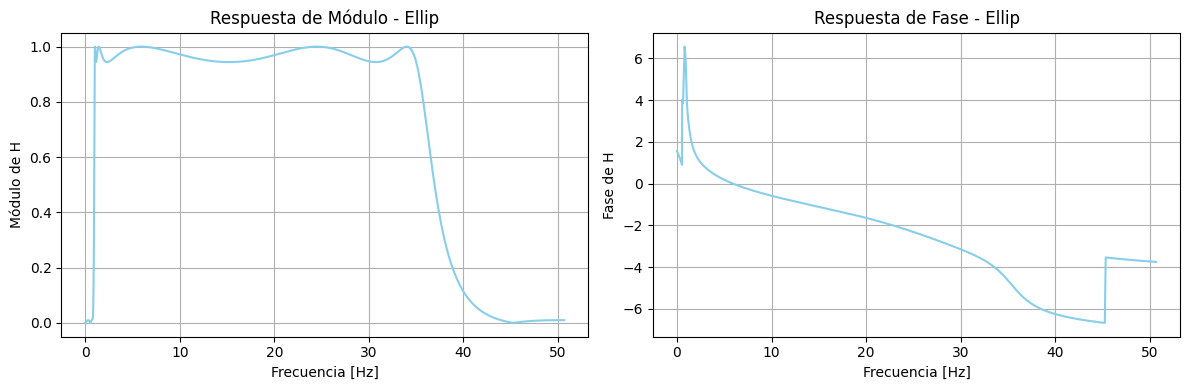

In [70]:
# Calcular módulo y fase
moduloH3 = np.abs(hh3)
faseH3 = np.unwrap(np.angle(hh3))

# Crear figura con dos subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Módulo
axs[0].plot(w3/np.pi*fs/2, moduloH3, color='skyblue')
axs[0].set_title('Respuesta de Módulo - Ellip')
axs[0].set_xlabel('Frecuencia [Hz]')
axs[0].set_ylabel('Módulo de H')
axs[0].grid(True)

# Fase
axs[1].plot(w3/np.pi*fs/2, faseH3, color='skyblue')
axs[1].set_title('Respuesta de Fase - Ellip')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set_ylabel('Fase de H')
axs[1].grid(True)

plt.tight_layout()
plt.show()

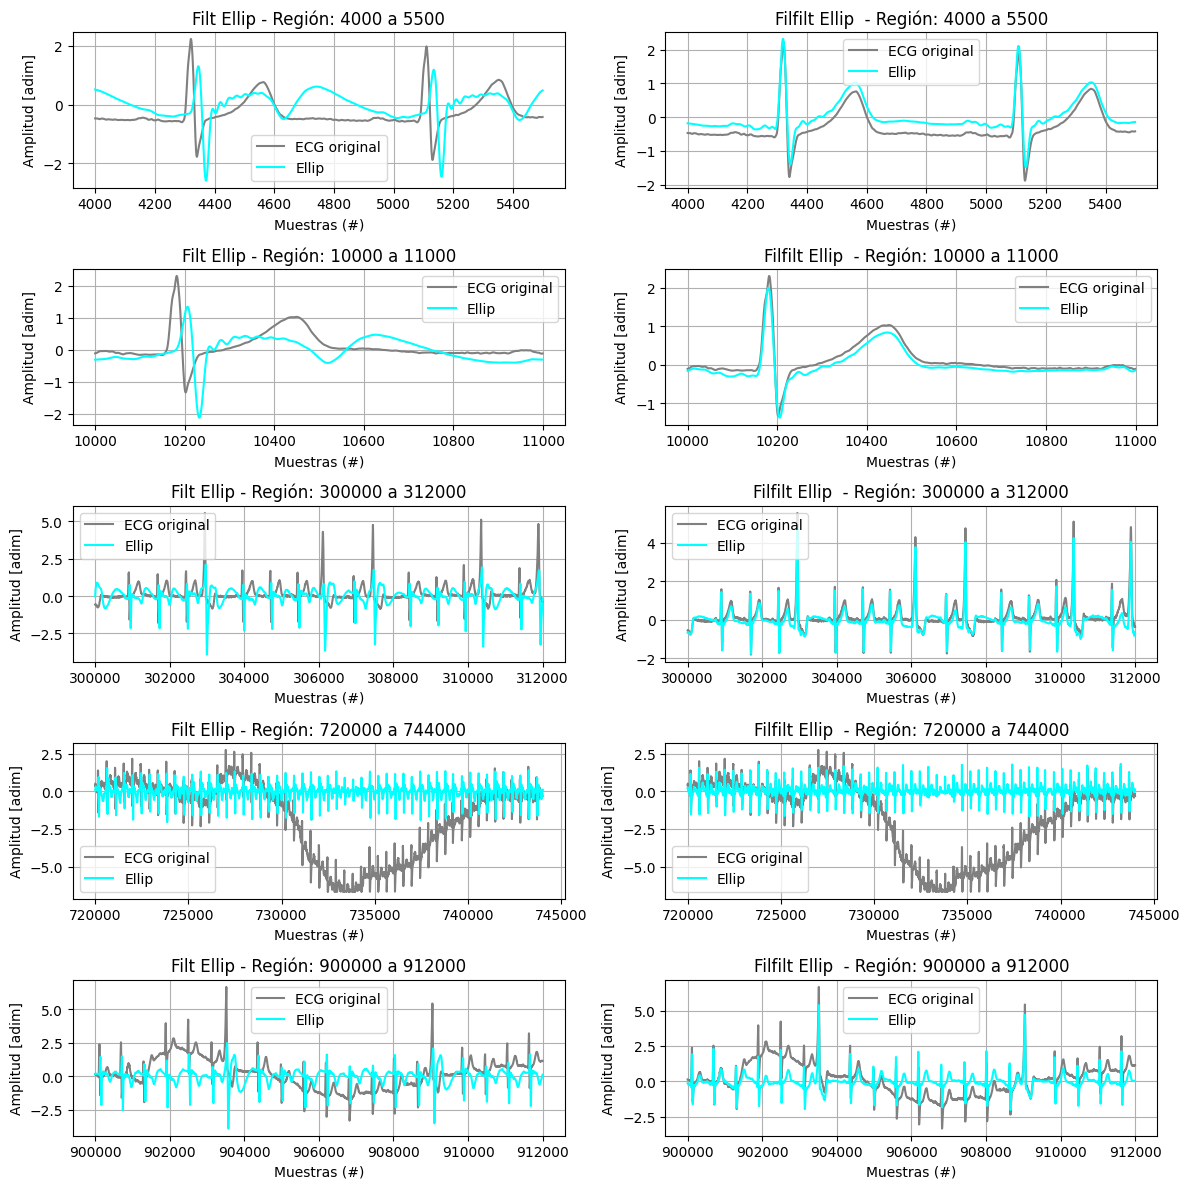

In [71]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))  # 5 regiones, 2 métodos
regs_interes = (
    [4000, 5500],
    [10000, 11000],
    np.array([5, 5.2]) * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

# Filtro causal en la columna 0
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_chevy], ['ellip'],
                        demora=[0], titulo='Filt Ellip',
                        mostrar=0, axs=axs[:, 0], regs_interes=regs_interes)

# Filtro no causal en la columna 1
visualizar_ecg_por_tipo(ecg_one_lead, [ecg_filtrado_chevy_ff], ['ellip'],
                        demora=[0], titulo='Filfilt Ellip ',
                        mostrar=0, axs=axs[:, 1], regs_interes=regs_interes)

plt.tight_layout()
plt.show()


**Análisis general de los IIR**

Ahora bien, la distorsión de fase  es cuando las distintas frecuencias de una señal se retrasan en el tiempo de forma desigual al pasar por un filtro. Esto cambia la forma original de la señal. Es lo que vimos, en los gráficos. Para distintas frecuencias la pendientes de la fase es distinta. Esto es un problema porque en una señal como un ECG se tiene componentes en muchas frecuencias, si esas frecuencias no se retrasan todas por igual, la forma de onda final se deforma.

Para evaluar el rendimiento de los filtros diseñados, se analizaron tanto la eliminación de señales interferentes como la preservación de la morfología del ECG en la banda de paso, es decir, en las regiones limpias. 

**FILT**

Voy a analizar un poco el efecto de filtrar con Butterworth. En las distintas regiones mostradas en las gráficas se observa con claridad la distorsión de fase introducida por el filtro Butterworth causal. 

En la región de 4000 a 5500 muestras, el complejo QRS aparece desplazado e incluso parcialmente invertido, lo que indica que sus componentes de frecuencia fueron afectadas de manera desigual. En la región de 10000 a 11000 muestras, se vuelve a ver un corrimiento de los picos y deformaciones en las ondas, reflejando nuevamente los efectos de una fase no lineal. En la región de 300000 a 312000 muestras, donde predominan componentes de alta frecuencia (como ruido o temblores), el filtro reduce el ruido pero también genera picos invertidos, señal de un desfase importante en esas frecuencias. Finalmente, en la región de 720000 a 744000, la onda de baja frecuencia aparece desplazada hacia la derecha, lo que puede afectar la medición de tiempos entre eventos en el ECG. Todos estos efectos son característicos de filtros IIR aplicados de forma causal, que poseen una respuesta en fase no lineal.
Para mitigar la distorsión de fase lo que se puede hacer es hacer un filtrado bidireccional con la función filtfilt de scipy signal. Es lo que muestro en los gráficos de la derecha. De este proceso obtenemos una fase nula. Esta técnica consiste en aplicar el filtro primero en el sentido directo (adelante en el tiempo) y luego en sentido inverso (hacia atrás en el tiempo).

**FILTFILT**

En el caso de los filtros IIR aplicados mediante filtrado bidireccional (filtfilt), se observó una fase nula, lo que implica que no hay distorsión de fase en la señal filtrada. Los resultados muestran que el filtro atenúa correctamente tanto las altas como las bajas frecuencias, eliminando ondulaciones rápidas (asociadas a artefactos de movimiento o ruido de alta frecuencia) y variaciones lentas (asociadas a tendencia de base, respiración o nivel de continua).

En la banda pasante, la señal filtrada mantiene una morfología general muy similar a la del ECG original sin ruido, lo cual indica que el filtro es en su mayoría inocuo, es decir, no altera sustancialmente la información relevante. No obstante, en la región comprendida entre las 30000 y 31200 muestras, se observan pequeñas diferencias en la forma de la onda P respecto de la señal original. Dado que ya se ha mitigado la distorsión de fase con el filtrado bidireccional, estas variaciones podrían deberse a la respuesta al impulso del filtro, influenciada por la exigente atenuación en las bandas de transición. Este comportamiento también se repite sutilmente en otras regiones limpias, especialmente al pasar del complejo QRS a la onda P.

Aunque estas diferencias existen, se trata de variaciones leves que no comprometen la interpretación clínica del ECG. Por tanto, se puede considerar que el filtro mantiene un buen compromiso entre eficiencia (eliminación de interferencias) e inocuidad (preservación de la señal), incluso en zonas donde no hay interferencias claras. En resumen, los filtros diseñados lograron suprimir adecuadamente las componentes no deseadas sin deformar significativamente la señal útil del ECG.



<div align="center">
    <h2><strong>CONCLUSIONES </strong></h2>
</div>
En el procesamiento de señales ECG, preservar la morfología es fundamental, ya que la forma, amplitud y duración de las ondas (P, QRS, T) son clave para el diagnóstico de patologías cardíacas. Por ello, los filtros FIR diseñados mediante el método de ventanas resultan especialmente apropiados, ya que presentan fase lineal, lo que permite mantener la alineación temporal de las componentes de la señal, y una banda pasante estable, sin ripple, lo cual reduce las posibilidades de alterar la forma de los complejos.
En comparación, los filtros IIR como Chebyshev o Elíptico pueden introducir ripple en la banda pasante y distorsión de fase, lo que puede afectar la forma de la señal en mayor medida. El filtro Butterworth, aunque con banda pasante plana, también es causal, y por ende introduce desfase que puede distorsionar la morfología en mayor o menor medida. 
Ahora bien, ningún filtro es completamente neutro, y aún los FIR pueden generar pequeños cambios en la señal, especialmente cuando se exigen atenuaciones elevadas en la banda de rechazo, lo cual puede traducirse en una respuesta al impulso más extendida y efectos secundarios leves. Por eso, es importante encontrar un equilibrio entre la selectividad del filtro y la fidelidad de la señal resultante.
En otras aplicaciones donde la morfología no es crítica (como en audio, comunicaciones u otras señales técnicas) puede preferirse el uso de filtros IIR por su menor complejidad computacional y su mayor eficiencia para lograr atenuaciones altas con filtros de menor orden.
En conclusión, en contextos como el ECG donde preservar la forma original es prioritario, los filtros FIR diseñados cuidadosamente y aplicados con fase nula (por ejemplo, usando filtfilt) son generalmente preferibles, aunque siempre se debe analizar el impacto del diseño elegido sobre la señal.
